# Install important library

In [24]:
%pip install rouge-score sacrebleu evaluate torchsummary

Note: you may need to restart the kernel to use updated packages.


# Import Library

In [ ]:
import re
import torch # type: ignore
import warnings
import evaluate # type: ignore
import numpy as np # type: ignore
import pandas as pd # type: ignore
from datasets import Dataset # type: ignore
import matplotlib.pyplot as plt # type: ignore
from collections import defaultdict
from sklearn.model_selection import train_test_split # type: ignore
from transformers import T5Tokenizer, T5ForConditionalGeneration
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer, DataCollatorForSeq2Seq, T5Config

In [26]:
warnings.filterwarnings("ignore")

# Cleaning Data

In [27]:
df = pd.read_csv('/kaggle/input/layoutlm/medquad.csv')

print("Data Sample")
print(df.head())

print('='*70)

print("Null Value Data")
print(df.isnull().sum())

print('='*70)

question_words = ['what', 'who', 'why', 'when', 'where', 'how', 'is', 'are', 'does', 'do', 'can', 'will', 'shall']

df['question'] = df['question'].str.lower()

df = df[df['question'].str.split().str[0].isin(question_words)]

df = df.reset_index(drop=True)

duplicates = df.duplicated()
print(f"Number of duplicate rows: {duplicates.sum()}")

print('='*70)

df = df.drop_duplicates()

df.reset_index(drop=True, inplace=True)

df = df.drop(columns=['source', 'focus_area'])

print("Table Info")
print(df.info())

print('='*70)

df = df.drop_duplicates(subset='question', keep='first').reset_index(drop=True)
df = df.drop_duplicates(subset='answer', keep='first').reset_index(drop=True)

df = df.drop_duplicates(subset=['question', 'answer']).reset_index(drop=True)
df['question'] = df['question'].fillna('').astype(str)
df['answer'] = df['answer'].fillna('').astype(str)

def clean_text(text):
	text = re.sub(r"\(.*?\)", "", text)
	text = re.sub(r'\s+', ' ', text.strip().lower())
	return text

df['question'] = df['question'].apply(clean_text)
df['answer'] = df['answer'].apply(clean_text)

df['question'] = df['question'].str.lower().str.strip().apply(lambda x: re.sub(r'\s+', ' ', x))
df['answer'] = df['answer'].str.lower().str.strip().apply(lambda x: re.sub(r'\s+', ' ', x))

print("Null Value Data")
print(df.isnull().sum())

print('='*70)

print(f"Unique questions: {df['question'].nunique()}")
print(f"Unique answers: {df['answer'].nunique()}")

df.info()
df.head()

Data Sample
                                 question  \
0                What is (are) Glaucoma ?   
1                  What causes Glaucoma ?   
2     What are the symptoms of Glaucoma ?   
3  What are the treatments for Glaucoma ?   
4                What is (are) Glaucoma ?   

                                              answer           source  \
0  Glaucoma is a group of diseases that can damag...  NIHSeniorHealth   
1  Nearly 2.7 million people have glaucoma, a lea...  NIHSeniorHealth   
2  Symptoms of Glaucoma  Glaucoma can develop in ...  NIHSeniorHealth   
3  Although open-angle glaucoma cannot be cured, ...  NIHSeniorHealth   
4  Glaucoma is a group of diseases that can damag...  NIHSeniorHealth   

  focus_area  
0   Glaucoma  
1   Glaucoma  
2   Glaucoma  
3   Glaucoma  
4   Glaucoma  
Null Value Data
question       0
answer         5
source         0
focus_area    14
dtype: int64
Number of duplicate rows: 48
Table Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1

,question,answer
0,what is glaucoma ?,glaucoma is a group of diseases that can damag...
1,what causes glaucoma ?,"nearly 2.7 million people have glaucoma, a lea..."
2,what are the symptoms of glaucoma ?,symptoms of glaucoma glaucoma can develop in o...
3,what are the treatments for glaucoma ?,"although open-angle glaucoma cannot be cured, ..."
4,who is at risk for glaucoma? ?,anyone can develop glaucoma. some people are a...


# Architecting Model

In [28]:
model_name = "t5-base"
config = T5Config.from_pretrained(model_name)
config.dropout_rate = 0.1
config.feed_forward_proj = "gelu"

model = T5ForConditionalGeneration.from_pretrained(model_name, config=config)
tokenizer = T5Tokenizer.from_pretrained(model_name)

model.resize_token_embeddings(len(tokenizer))

Embedding(32100, 768)

In [29]:
def summarize_model_by_type(model):
	layer_summary = defaultdict(int)
	param_summary = defaultdict(int)
	for name, module in model.named_modules():
			layer_type = type(module).__name__
			layer_summary[layer_type] += 1
			param_summary[layer_type] += sum(p.numel() for p in module.parameters())
	print(f"{'Layer Type':<30}{'Count':<10}{'Parameters':<15}")
	print("=" * 55)
	for layer_type, count in layer_summary.items():
			print(f"{layer_type:<30}{count:<10}{param_summary[layer_type]:<15,}")

summarize_model_by_type(model)

Layer Type                    Count     Parameters     
T5ForConditionalGeneration    1         222,882,048    
Embedding                     3         24,653,568     
T5Stack                       2         247,534,848    
ModuleList                    26        396,455,424    
T5Block                       24        198,227,712    
T5LayerSelfAttention          24        56,642,304     
T5Attention                   36        84,935,424     
Linear                        193       222,833,664    
T5LayerNorm                   62        47,616         
Dropout                       86        0              
T5LayerFF                     24        113,264,640    
T5DenseActDense               24        113,246,208    
ReLU                          24        0              
T5LayerCrossAttention         12        28,320,768     


In [30]:
def preprocess_function(batch):
    inputs = [f"answer the following question: {q}" for q in batch['question']]
    targets = [str(a) for a in batch['answer']]

    model_inputs = tokenizer(
        inputs,
        max_length=128,
        truncation=True,
        padding="max_length"
    )

    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            targets,
            max_length=64,
            truncation=True,
            padding="max_length"
        )

    labels["input_ids"] = [
        [(l if l != tokenizer.pad_token_id else -100) for l in label]
        for label in labels["input_ids"]
    ]
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [ ]:
train_df, val_df = train_test_split(df, test_size=0.15, random_state=42)

train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

train_dataset = train_dataset.map(
	preprocess_function,
	batched=True,
	batch_size=32,
	remove_columns=train_dataset.column_names,
	num_proc=4,
)

val_dataset = val_dataset.map(
	preprocess_function,
	batched=True,
	batch_size=32,
	remove_columns=val_dataset.column_names,
	num_proc=4,
)

In [32]:
training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    save_total_limit=2,
    learning_rate=5e-4,
    num_train_epochs=5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    lr_scheduler_type="cosine_with_restarts",
    warmup_ratio=0.1,
    weight_decay=0.05,
    predict_with_generate=True,
    fp16=True,
    logging_dir="./logs",
    logging_steps=50,
    metric_for_best_model="exact_match",
    greater_is_better=True,
    report_to="none",
    gradient_accumulation_steps=2,
    max_grad_norm=0.5,
    optim="adamw_torch_fused",
    generation_max_length=64,
    generation_num_beams=6,
    dataloader_num_workers=4,
    group_by_length=True,
    remove_unused_columns=True,
    label_smoothing_factor= 0.1
)

data_collator = DataCollatorForSeq2Seq(
	tokenizer=tokenizer,
	model=model,
	padding='longest'
)

In [33]:
def compute_metrics(eval_pred):
	predictions, labels = eval_pred
	decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
	labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
	decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

	decoded_preds = [text.strip().lower() for text in decoded_preds]
	decoded_labels = [text.strip().lower() for text in decoded_labels]

	exact_match = np.mean([p == l for p, l in zip(decoded_preds, decoded_labels)])

	bleu_metric = evaluate.load("bleu")
	rouge_metric = evaluate.load("rouge")

	bleu_score = bleu_metric.compute(
		predictions=decoded_preds,
		references=[[label] for label in decoded_labels]
	)["bleu"]

	rouge_score = rouge_metric.compute(
		predictions=decoded_preds,
		references=decoded_labels
	)["rougeL"]

	return {
		"exact_match": exact_match,
		"BLEU": bleu_score,
		"ROUGE-L": rouge_score,
	}

In [34]:
data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=model,
    padding='longest',
    return_tensors="pt"
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=lambda eval_pred: compute_metrics(eval_pred, tokenizer)
)

In [35]:
trainer.train()

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Step,Training Loss
50,4.139500
100,3.450200
150,3.235500
200,3.130100
250,3.054400
300,3.082900
350,2.989300
400,2.866700
450,2.889100
500,2.860600


TrainOutput(global_step=1840, training_loss=2.78688381858494, metrics={'train_runtime': 2059.5846, 'train_samples_per_second': 28.596, 'train_steps_per_second': 0.893, 'total_flos': 8946200370216960.0, 'train_loss': 2.78688381858494, 'epoch': 4.987788331071913})

In [36]:
trainer.save_model("./t5_chatbot_model")
tokenizer.save_pretrained("./t5_chatbot_tokenizer")
model_path = "./t5_chatbot_model.h5"
torch.save(model.state_dict(), model_path)

In [50]:
log_history = trainer.state.log_history

# Show graphics

In [57]:
train_loss = []
eval_loss = []
eval_bleu = []
eval_exact_match = []
eval_rogue = []
steps = []
eval_steps = []

for log in log_history:
	if "loss" in log:
		train_loss.append(log["loss"])
		steps.append(log["step"])

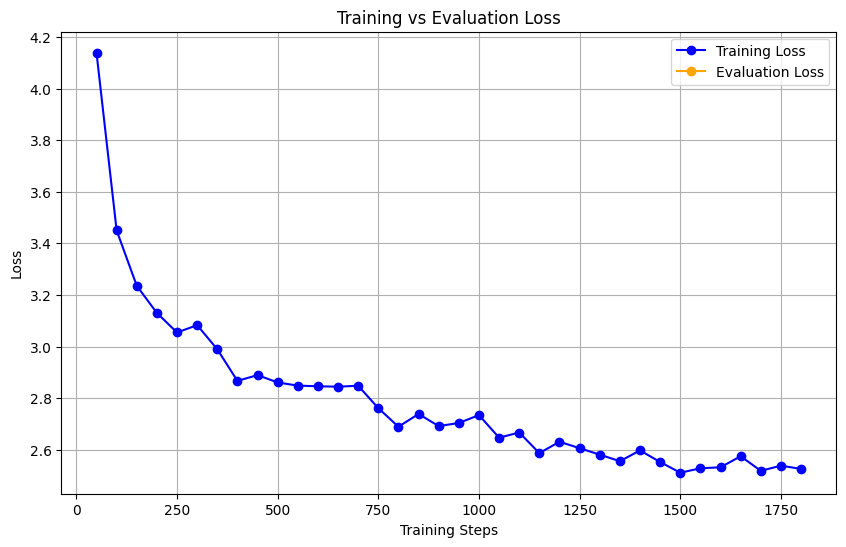

In [58]:
plt.figure(figsize=(10, 6))
plt.plot(steps, train_loss, label="Training Loss", color="blue", marker="o")
plt.plot(steps[:len(eval_loss)], eval_loss, label="Evaluation Loss", color="orange", marker="o")
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("Training vs Evaluation Loss")
plt.legend()
plt.grid(True)
plt.show()

# Testing using Input

In [59]:
model_path = "/kaggle/working/t5_chatbot_model"
tokenizer_path = "/kaggle/working/t5_chatbot_tokenizer"

tokenizer = T5Tokenizer.from_pretrained(tokenizer_path)
model = T5ForConditionalGeneration.from_pretrained(model_path)
model.eval()

def generate_response_top_k_top_p(
	question, model, tokenizer, max_length=64, top_k=50, top_p=0.95, temperature=1.0
):
	formatted_question = f"Answer the following question: {question}"
	
	inputs = tokenizer(
			formatted_question,
			return_tensors="pt",
			padding=True,
			truncation=True,
			max_length=128,
    )
	outputs = model.generate(
			input_ids=inputs["input_ids"],
			attention_mask=inputs["attention_mask"],
			max_length=max_length,
			do_sample=True,
			top_k=top_k,
			top_p=top_p,
			temperature=temperature,
			pad_token_id=tokenizer.pad_token_id,
	)
	response = tokenizer.decode(outputs[0], skip_special_tokens=True)

	return response

In [54]:
question = "What is alzheimer?"
response = generate_response_top_k_top_p(question, model, tokenizer)
print("Question:", question)
print("="*50)
print("Response:", response)

Question: What is alzheimer?
Response: alzheimer is a brain disorder that leads to intellectual disability. it can affect any organ, including the brain, spinal cord and limbs. alzheimer's means loss of memory and attention. alzheimer's înseamns that the inner workings of the brain are gone


In [55]:
question = "I had a surgery which ended up with some failures. What can I do to fix it?"
response = generate_response_top_k_top_p(question, model, tokenizer)
print("Question:", question)
print("="*50)
print("Response:", response)

Question: I had a surgery which ended up with some failures. What can I do to fix it?
Response: the following steps can be taken to help prevent surgery and improve your chances of success: - make sure all of the equipment you use comes to life according to the instructions in the manual. - listen to the pros and cons of the surgery and take your time to follow the recommended procedures. - make sure


In [60]:
question = "I have pain in my back"
response = generate_response_top_k_top_p(question, model, tokenizer)
print("Question:", question)
print("="*50)
print("Response:", response)

Question: I have pain in my back
Response: pain in my back, or back, usually occurs if a muscle or another item damages a nerve or muscles that control their muscles or movements. in addition to backache, you may also get pain on your shoulders, abdomen, or arms. if your pain is in the left or right hand,


In [61]:
question = "how to check if i have cancer"
response = generate_response_top_k_top_p(question, model, tokenizer)
print("Question:", question)
print("="*50)
print("Response:", response)

Question: how to check if i have cancer
Response: a health care provider might ask you if you have a problem with your cholesterol, blood or blood, or if you have liver disease. a health care provider can sometimes tell if you have cancer from a blood test, a physical exam, or an ultrasound. the health care provider


In [62]:
question = "i think i have liver failure what should i do"
response = generate_response_top_k_top_p(question, model, tokenizer)
print("Question:", question)
print("="*50)
print("Response:", response)

Question: i think i have liver failure what should i do
Response: if you have liver failure, you probably shouldeat a high-fiber diet because there may be extra fat in your blood. however, some foods that you may not need are high in fat and high in sodium. you should take your medicine whenever you have a problem with your blood clotting.


## Upload To Hugging Face

In [68]:
%pip install -U huggingface_hub

Note: you may need to restart the kernel to use updated packages.


In [ ]:
model = T5ForConditionalGeneration.from_pretrained("/kaggle/working/t5_chatbot_model")
tokenizer = T5Tokenizer.from_pretrained("/kaggle/working/t5_chatbot_tokenizer")

hf_repo_name = "Dr_Chatbot"

# Push to Hugging Face Hub
model.push_to_hub(hf_repo_name)
tokenizer.push_to_hub(hf_repo_name)